# Exploring Singapore's food culture at MRT Interchanges

## Introduction

**Background**

Singapore's Mass Rapid Transport (MRT) is well connected is one of the main transport mode in the country. In 2019, the average daily ridership is at 3.384 million, which is about half the population of Singapore. 

Like any country, going out for food and drinks is common and is a part of the culture where people spending time catching-up with each other, or just trying out new places. Similarly, businesses are also changing, and new ones are appearing. 

**Problem area**

Singapore is a small country and business competition is high. For both business owners and customers, there are too many options to choose from, or compete against.

For this project, we will try to determine the top 10 food and drinks places located around major MRT interchanges. 

**Target Audience**

Hopefully, this observation can help new business owners understand the landscape just a little more before they startup, as well as to help customers  pick their next outing. 

**Scope**

For the purpose of this project, MRT interchanges are the main train networks that connects 2 or more other networks, and excludes those that connects to Light Rail Transits stations.

## Data

The datasets required for this analysis are:

1. List of MRT interchanges and its latitude and longitude. The source can be found in [data.world](https://data.world/hxchua/train-stations-in-singapore) and has the features required:
    1. stn_name
    2. stn_no
    3. latitude
    4. longitude
    5. color (color of the MRT network link)  
    
2. Data for busiest MRT interchanges. [mytransport.sg](http://mytransport.sg) provides monthly ridership statistics, however the data needs to be understood further before using, as it records the entry and exits of the station gantries instead of the passenger count.
3. Nearby venues from Foursquare. We will be using the `explore` API endpoint to source for venues near each of the MRT interchange

At this point, the following sources are identified:

- data.gov.sg
- mytransport.sg
- data.world
- Wikipedia
- Foursquare

## Methodology

### Import required libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import folium
import matplotlib.pyplot as plt
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim

# import k-means from clustering stage
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print ("Libraries loaded")

Libraries loaded


### 1. Identifying MRT Interchanges
We'll start by taking a look at the list of MRT stations taken from the data.world source. 

In [2]:
sg_mrt_stations_all = pd.read_csv( "data/dataworld-singapore-mrt-stations.csv" )

In [3]:
sg_mrt_stations_all.head(15)

,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,COLOR
0,12,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,RED
1,16,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,GREEN
2,33,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,RED
3,81,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS
4,80,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS
5,153,BARTLEY MRT STATION,CC12,33168.3039,36108.7003,1.342828,103.879746,YELLOW
6,115,BAYFRONT MRT STATION,DT16,30867.0093,29368.6250,1.281874,103.859073,BLUE
7,115,BAYFRONT MRT STATION,CE1,30867.0093,29368.6250,1.281874,103.859073,OTHERS
8,140,BEAUTY WORLD MRT STATION,DT5,21598.1665,35931.2359,1.341223,103.775810,BLUE
9,37,BEDOK MRT STATION,EW5,38757.9520,34024.7048,1.323980,103.929959,GREEN


## Clean up the columns

In [4]:
# remove columns we don't need
sg_mrt_stations_all.drop( ['OBJECTID', 'X', 'Y' ], axis=1, inplace=True )

# rename some columns
sg_mrt_stations_all.rename( columns={ 'Latitude': 'LATITUDE', 'Longitude':'LONGITUDE' }, inplace=True)

# convert color values to lowercase
sg_mrt_stations_all['COLOR'] = sg_mrt_stations_all['COLOR'].str.lower()

sg_mrt_stations_all.head()

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR
0,ADMIRALTY MRT STATION,NS10,1.440585,103.800998,red
1,ALJUNIED MRT STATION,EW9,1.316433,103.882893,green
2,ANG MO KIO MRT STATION,NS16,1.369933,103.849553,red
3,BAKAU LRT STATION,SE3,1.388093,103.905418,others
4,BANGKIT LRT STATION,BP9,1.380018,103.772667,others


In [5]:
# check the shape
sg_mrt_stations_all.shape

(187, 5)

The data provided is structured in a way that the MRT station names that are interchanges are repeated for each train network it is connected to. We know (from local knowledge) that '**Dhoby Ghaut**' station has 3 stations connected to it, let's confirm this.

In [7]:
sg_mrt_stations_all[ sg_mrt_stations_all.STN_NAME == 'DHOBY GHAUT MRT STATION'] # should return 3 rows

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR
51,DHOBY GHAUT MRT STATION,NS24,1.298701,103.846112,red
52,DHOBY GHAUT MRT STATION,NE6,1.299705,103.845485,purple
53,DHOBY GHAUT MRT STATION,CC1,1.298843,103.846236,yellow


We can confirm that it is indeed connected to 3 stations; **NS24**, **NE6**, and **CC1**.  We can now get a list of interchanges based on the number of stations connected to it:

In [9]:
sg_mrt_stations_all_grouped = sg_mrt_stations_all.loc[:].groupby('STN_NAME').count()
sg_mrt_stations_all_grouped.rename( columns = { 'STN_NO' : 'TOTAL_STNS' }, inplace=True)
sg_mrt_stations_all_grouped[ ['TOTAL_STNS'] ].sort_values( ['TOTAL_STNS'], ascending=False ).head(10)

,TOTAL_STNS
STN_NAME,
DHOBY GHAUT MRT STATION,3
BOTANIC GARDENS MRT STATION,2
SERANGOON MRT STATION,2
HARBOURFRONT MRT STATION,2
RAFFLES PLACE MRT STATION,2
CITY HALL MRT STATION,2
PROMENADE MRT STATION,2
CHINATOWN MRT STATION,2
TAMPINES MRT STATION,2


From the list above, we can check if **DHOBY GHAUT MRT STATION** is connected to **3** train network lines:

With this, we will now proceed with further cleaning and drop rows that are not interchanges.

In [10]:
# Create a dataframe of the interchange names


mrt_interchange_names = sg_mrt_stations_all_grouped.loc[:].reset_index()

# get the indexes of non-interchange stations
indexes_to_drop = mrt_interchange_names[ mrt_interchange_names['TOTAL_STNS'] == 1 ].index 

# drop them
mrt_interchange_names.drop(indexes_to_drop, inplace = True)
mrt_interchange_names.drop(['LATITUDE', 'LONGITUDE', 'COLOR'], axis=1, inplace=True)
mrt_interchange_names.reset_index(inplace=True, drop=True)

mrt_interchange_names.head()

,STN_NAME,TOTAL_STNS
0,BAYFRONT MRT STATION,2
1,BISHAN MRT STATION,2
2,BOTANIC GARDENS MRT STATION,2
3,BUGIS MRT STATION,2
4,BUONA VISTA MRT STATION,2


The list above shows interchanges only. We will now add a boolean column

In [11]:

# add a column to indicate which station is an interchange
sg_mrt_stations_all['IS_INTERCHANGE'] = sg_mrt_stations_all['STN_NAME'].isin( mrt_interchange_names['STN_NAME'] )

# create a new dataframe that are interchanges
mrt_interchanges = sg_mrt_stations_all.loc[ sg_mrt_stations_all['IS_INTERCHANGE'] == True ].copy()
mrt_interchanges.reset_index(inplace=True, drop=True)
mrt_interchanges.head()

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
0,BAYFRONT MRT STATION,DT16,1.281874,103.859073,blue,True
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,others,True
2,BISHAN MRT STATION,CC15,1.351309,103.849150,yellow,True
3,BISHAN MRT STATION,NS17,1.350839,103.848140,red,True
4,BOTANIC GARDENS MRT STATION,DT9,1.322424,103.816136,blue,True


The provided data contains a **'COLOR'** column which corresponds to color assigned to the train network line. We note that there are colors assigned as 'Others':

In [12]:
mrt_interchanges[ mrt_interchanges['COLOR'] == 'others' ]

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,others,True
17,EXPO MRT STATION,CG1,1.334550,103.961513,others,True
28,MARINA BAY MRT STATION,CE2,1.276151,103.855089,others,True
44,WOODLANDS MRT STATION,TE2,1.436067,103.787945,others,True


We will correct these values manually as it is faster that to do so. Color references can be checked here: https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations#MRT_stations

In [13]:
# Update using the indexes from the table above
mrt_interchanges.loc[1, 'COLOR'] = 'yellow'
mrt_interchanges.loc[17, 'COLOR'] = 'green'
mrt_interchanges.loc[28, 'COLOR'] = 'yellow'
mrt_interchanges.loc[44, 'COLOR'] = 'brown'


# let's check the values again
mrt_interchanges.loc[[1, 17, 28, 44]]

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,yellow,True
17,EXPO MRT STATION,CG1,1.334550,103.961513,green,True
28,MARINA BAY MRT STATION,CE2,1.276151,103.855089,yellow,True
44,WOODLANDS MRT STATION,TE2,1.436067,103.787945,brown,True


Now we will plot these on a map to visulize their positions.

In [14]:
address = 'Singapore, SG'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Static value in case Nominatim goes down
# latitude = '1.3408630000000001'
# longitude = '103.83039182212079'

print('The geograpical coordinate of Singapore is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore is 1.3408630000000001, 103.83039182212079.


In [15]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')


# add markers to map
for lat, lng, label, color in zip(mrt_interchanges['LATITUDE'], mrt_interchanges['LONGITUDE'], mrt_interchanges['STN_NAME'] + "(" + mrt_interchanges['STN_NO'] + ")", mrt_interchanges['COLOR'] ):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
    
map

We have now plotted the stations on each interchange, however, we are more concerned with the general area of these interchanges. Let's clean up the data little further but grouping the data by interchange name and using the `mean` for its latitude and longitude

In [16]:
    
mean_coords = mrt_interchanges.copy()
mean_coords.drop(['STN_NO', 'COLOR'], axis=1, inplace=True )
mean_coords = mean_coords.groupby('STN_NAME').mean()
mean_coords.reset_index(inplace=True)
# print(mean_coords.shape)
# print( mean_coords[ mean_coords['STN_NAME'] == 'BISHAN MRT STATION'] )

current_station = ''

mrt_interchanges_mean = pd.DataFrame(columns=['STN_NAME', 'MEAN_LATITUDE', 'MEAN_LONGITUDE'] ).copy()

for index, row in mrt_interchanges.iterrows():
    
    if( current_station != row['STN_NAME'] ):
        
        if(current_station != ''):
            mrt_interchanges_mean = mrt_interchanges_mean.append({
                'STN_NAME': current_station, 
                'MEAN_LATITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LATITUDE'].iloc[0],
                'MEAN_LONGITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LONGITUDE'].iloc[0]
            }, ignore_index=True)
        
        current_station = row['STN_NAME']
#         print(current_station)
        

# save the last data    
mrt_interchanges_mean = mrt_interchanges_mean.append({
    'STN_NAME': current_station, 
    'MEAN_LATITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LATITUDE'].iloc[0],
    'MEAN_LONGITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LONGITUDE'].iloc[0]
}, ignore_index=True)

# check that we have the same number of rows
mean_coords.shape[0] == mrt_interchanges_mean.shape[0]

True

Now, **Dhoby Ghaut** should only contain 1 row, with a mean latitude and longitude.

In [18]:
mrt_interchanges_mean[ mrt_interchanges_mean["STN_NAME"] == "DHOBY GHAUT MRT STATION" ]

,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
7,DHOBY GHAUT MRT STATION,1.299083,103.845944


Check again how many interchanges we have.

In [19]:
mrt_interchanges_mean.shape

(22, 3)

We have **22 interchanges**. 

Quick look at the data and plot them on the map:

In [17]:
mrt_interchanges_mean.head()

,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,BAYFRONT MRT STATION,1.281874,103.859073
1,BISHAN MRT STATION,1.351074,103.848645
2,BOTANIC GARDENS MRT STATION,1.322267,103.815562
3,BUGIS MRT STATION,1.300008,103.856281
4,BUONA VISTA MRT STATION,1.306838,103.790434


In [20]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')


# add markers to map
for lat, lng, label in zip(mrt_interchanges_mean['MEAN_LATITUDE'], mrt_interchanges_mean['MEAN_LONGITUDE'], mrt_interchanges_mean['STN_NAME'] ):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
    
map

### Now we have plotted a map showing the 22 MRT interchanges in Singapore. Next we will figure out which of these are the most busiest

## 2. Exploring the busiest interchanges  

The data we are using is provided by Singapore's Land Trasport Authority. We will be using the data from October 2020.

Load the data.

In [21]:
passengers_oct2020 = pd.read_csv('data/transport_node_train_202010.csv')

Examine the data.

In [22]:
passengers_oct2020.head(15)

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2020-10,WEEKDAY,11,TRAIN,NS7,2353,1912
1,2020-10,WEEKENDS/HOLIDAY,11,TRAIN,NS7,1434,1940
2,2020-10,WEEKDAY,16,TRAIN,SW4,1033,1457
3,2020-10,WEEKENDS/HOLIDAY,16,TRAIN,SW4,514,522
4,2020-10,WEEKDAY,10,TRAIN,CC5,1319,3515
5,2020-10,WEEKENDS/HOLIDAY,10,TRAIN,CC5,628,1336
6,2020-10,WEEKDAY,13,TRAIN,CC23,8021,8550
7,2020-10,WEEKENDS/HOLIDAY,13,TRAIN,CC23,1230,1328
8,2020-10,WEEKENDS/HOLIDAY,22,TRAIN,EW33,249,323
9,2020-10,WEEKDAY,22,TRAIN,EW33,727,547


The data shows the hourly (TIME_PER_HOUR) taps in and out of each station, separated by Weekdays and Weekends/Holiday. We will clean up the data now by doing a few things:
- Create a new **AVG_PASSENGERS** column as a mean of the **Tap In** and **Tap Out** values
- Drop the **Tap In** and **Tap Out** columns after calculating the mean
- Drop the **PT_TYPE** column as we know that this data is for TRAIN only. 

In [23]:
# get the mean of passengers moving through the station
passengers_oct2020['AVG_PASSENGERS'] = passengers_oct2020[['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'] ] .mean(axis=1)

# remove columns we don't need
passengers_oct2020.drop( ['PT_TYPE', 'TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'], axis=1, inplace=True )
# passengers_oct2020.drop( 'PT_TYPE', axis=1, inplace=True )

In [24]:
passengers_oct2020.head(15)

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,AVG_PASSENGERS
0,2020-10,WEEKDAY,11,NS7,2132.5
1,2020-10,WEEKENDS/HOLIDAY,11,NS7,1687.0
2,2020-10,WEEKDAY,16,SW4,1245.0
3,2020-10,WEEKENDS/HOLIDAY,16,SW4,518.0
4,2020-10,WEEKDAY,10,CC5,2417.0
5,2020-10,WEEKENDS/HOLIDAY,10,CC5,982.0
6,2020-10,WEEKDAY,13,CC23,8285.5
7,2020-10,WEEKENDS/HOLIDAY,13,CC23,1279.0
8,2020-10,WEEKENDS/HOLIDAY,22,EW33,286.0
9,2020-10,WEEKDAY,22,EW33,637.0


Interchanges in this datasets are separates by a '/' on the **PT_CODE** column:

In [25]:
passengers_oct2020[ passengers_oct2020.PT_CODE.str.contains('/') ].head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,AVG_PASSENGERS
12,2020-10,WEEKDAY,18,EW24/NS1,147108.0
13,2020-10,WEEKENDS/HOLIDAY,18,EW24/NS1,36946.5
22,2020-10,WEEKENDS/HOLIDAY,6,NS24/NE6/CC1,1348.5
23,2020-10,WEEKDAY,6,NS24/NE6/CC1,5435.5
26,2020-10,WEEKDAY,10,CC22/EW21,12375.0


Additionally, the data does not contain any station names. We will  address it by doing the following:
1. Splitting the values by '/', and then duplicate row with each PT_CODE value
2. Assign the station names using the data from the previous section
3. Remove the duplicates

#### 1. Splitting the values by '/', and then duplicate row with each PT_CODE value

In [26]:
passengers_oct2020_temp = ( passengers_oct2020.set_index( passengers_oct2020.columns.drop('PT_CODE', 1).tolist())
   .PT_CODE.str.split('/', expand=True)
   .stack()
   .reset_index()
   .rename(columns={0:'PT_CODE'})
   .loc[:, passengers_oct2020.columns]
)

passengers_oct2020_temp.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,AVG_PASSENGERS
0,2020-10,WEEKDAY,11,NS7,2132.5
1,2020-10,WEEKENDS/HOLIDAY,11,NS7,1687.0
2,2020-10,WEEKDAY,16,SW4,1245.0
3,2020-10,WEEKENDS/HOLIDAY,16,SW4,518.0
4,2020-10,WEEKDAY,10,CC5,2417.0


We can use the **AVG_PASSENGERS** value of `1348.5` for `NS24/NE6/CC1` (see `head()` above), to check if they are indeed splitted out into 3 rows

In [27]:
passengers_oct2020_temp[ passengers_oct2020_temp.AVG_PASSENGERS == 1348.5 ] # all ok

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,AVG_PASSENGERS
24,2020-10,WEEKENDS/HOLIDAY,6,NS24,1348.5
25,2020-10,WEEKENDS/HOLIDAY,6,NE6,1348.5
26,2020-10,WEEKENDS/HOLIDAY,6,CC1,1348.5


#### 2. Assign the station names using the data from the previous section

Now we will merge the data with `mrt_interchanges`

In [28]:
# we will merge both data on the MRT station column.

passengers_oct2020_merged = passengers_oct2020_temp.merge(
    mrt_interchanges,
    left_on='PT_CODE',
    right_on='STN_NO'
)

passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,AVG_PASSENGERS,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
0,2020-10,WEEKDAY,18,EW24,147108.0,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
1,2020-10,WEEKENDS/HOLIDAY,18,EW24,36946.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
2,2020-10,WEEKDAY,11,EW24,45338.0,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
3,2020-10,WEEKENDS/HOLIDAY,11,EW24,24881.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
4,2020-10,WEEKENDS/HOLIDAY,22,EW24,15347.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True


Let's confirm the merge is correct. We'll compare the name of interchange `NE6`

In [29]:
print( passengers_oct2020_merged[ passengers_oct2020_merged.PT_CODE=='NE6'].iloc[0, 5] )
print( mrt_interchanges[ mrt_interchanges.STN_NO =='NE6' ].iloc[0, 0] )

passengers_oct2020_merged[ passengers_oct2020_merged.PT_CODE=='NE6'].iloc[0, 5] == mrt_interchanges[ mrt_interchanges.STN_NO =='NE6' ].iloc[0, 0]

DHOBY GHAUT MRT STATION
DHOBY GHAUT MRT STATION


True

#### 3. Remove the duplicates

When the station codes are splitted by '`/`', it created duplicated rows with the same values for other columns. 
After the data is merged, we get the same station name joined per station code. For example, **`NS24/NE6/CC1`** station codes will each get the name '**Dhoby Ghaut**'. So we will remove these duplicates.

To do this, we will remove unused columns including station codes (e.g, NE6)

In [30]:
passengers_oct2020_merged.drop( ['PT_CODE', 'STN_NO', 'COLOR', 'IS_INTERCHANGE', 'LATITUDE', 'LONGITUDE'], axis=1, inplace=True)

In [31]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,AVG_PASSENGERS,STN_NAME
0,2020-10,WEEKDAY,18,147108.0,JURONG EAST MRT STATION
1,2020-10,WEEKENDS/HOLIDAY,18,36946.5,JURONG EAST MRT STATION
2,2020-10,WEEKDAY,11,45338.0,JURONG EAST MRT STATION
3,2020-10,WEEKENDS/HOLIDAY,11,24881.5,JURONG EAST MRT STATION
4,2020-10,WEEKENDS/HOLIDAY,22,15347.5,JURONG EAST MRT STATION


In [32]:
# Join the mean lat/long columns
passengers_oct2020_merged = passengers_oct2020_merged.merge( 
    mrt_interchanges_mean,
    on='STN_NAME'   
)

In [33]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,AVG_PASSENGERS,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,2020-10,WEEKDAY,18,147108.0,JURONG EAST MRT STATION,1.333153,103.742311
1,2020-10,WEEKENDS/HOLIDAY,18,36946.5,JURONG EAST MRT STATION,1.333153,103.742311
2,2020-10,WEEKDAY,11,45338.0,JURONG EAST MRT STATION,1.333153,103.742311
3,2020-10,WEEKENDS/HOLIDAY,11,24881.5,JURONG EAST MRT STATION,1.333153,103.742311
4,2020-10,WEEKENDS/HOLIDAY,22,15347.5,JURONG EAST MRT STATION,1.333153,103.742311


In [37]:
passengers_oct2020_merged.shape # the data printed below includes the duplicated station names

(1800, 7)

In [41]:
passengers_oct2020_merged = passengers_oct2020_merged.drop_duplicates().copy()

In [42]:
passengers_oct2020_merged.sort_values('TIME_PER_HOUR', ascending=True, inplace=True)
passengers_oct2020_merged.reset_index(inplace=True, drop=True)

In [43]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,AVG_PASSENGERS,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,2020-10,WEEKENDS/HOLIDAY,0,296.0,PAYA LEBAR MRT STATION,1.317771,103.892604
1,2020-10,WEEKENDS/HOLIDAY,0,171.0,BAYFRONT MRT STATION,1.281874,103.859073
2,2020-10,WEEKDAY,0,579.5,PAYA LEBAR MRT STATION,1.317771,103.892604
3,2020-10,WEEKDAY,0,363.0,BAYFRONT MRT STATION,1.281874,103.859073
4,2020-10,WEEKENDS/HOLIDAY,0,1591.5,WOODLANDS MRT STATION,1.436471,103.787222


### Prepare data for plotting

Now let's figure which station has the highest number of passengers. To do this, we will sum the AVG_PASSENGERS for each station

In [45]:
passengers_plot = passengers_oct2020_merged[['STN_NAME', 'DAY_TYPE', 'TIME_PER_HOUR', 'AVG_PASSENGERS']].copy()
passengers_plot = passengers_plot.pivot_table(
    index=['STN_NAME', 'DAY_TYPE'],
    columns='TIME_PER_HOUR',
    values='AVG_PASSENGERS'
)
passengers_plot['TOTAL_PASSENGERS'] = passengers_plot.sum(axis=1)

passengers_plot.rename_axis(None, axis=1)
passengers_plot.reset_index(inplace=True)

passengers_plot = passengers_plot[['STN_NAME', 'DAY_TYPE', 'TOTAL_PASSENGERS']]
passengers_plot = passengers_plot.pivot_table(
    index=['STN_NAME'],
    columns='DAY_TYPE',
    values='TOTAL_PASSENGERS'
)
passengers_plot.reset_index(inplace=True)
passengers_plot.rename(columns= {'WEEKDAY': 'WEEKDAY_TOTAL', 'WEEKENDS/HOLIDAY':'WEEKENDS_TOTAL'}, inplace=True)
passengers_plot['TOTAL_PASSENGERS'] = passengers_plot.sum(axis=1)
passengers_plot.columns.name = None

passengers_plot.sort_values('TOTAL_PASSENGERS', ascending=False, inplace=True)

passengers_plot


,STN_NAME,WEEKDAY_TOTAL,WEEKENDS_TOTAL,TOTAL_PASSENGERS
10,JURONG EAST MRT STATION,1190389.5,440142.5,1630532.0
20,TAMPINES MRT STATION,815781.0,288823.0,1104604.0
14,NEWTON MRT STATION,799639.5,291275.0,1090914.5
21,WOODLANDS MRT STATION,769262.5,259253.5,1028516.0
16,PAYA LEBAR MRT STATION,649757.5,288387.0,938144.5
5,CHINATOWN MRT STATION,639635.0,267550.0,907185.0
3,BUGIS MRT STATION,605781.0,289091.5,894872.5
9,HARBOURFRONT MRT STATION,473998.5,240339.5,714338.0
6,CITY HALL MRT STATION,457194.0,229487.0,686681.0
7,DHOBY GHAUT MRT STATION,411507.5,193438.5,604946.0


In [46]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

### Plot the busiest stations

Let's take a look at how all the stations rank by average daily passengers

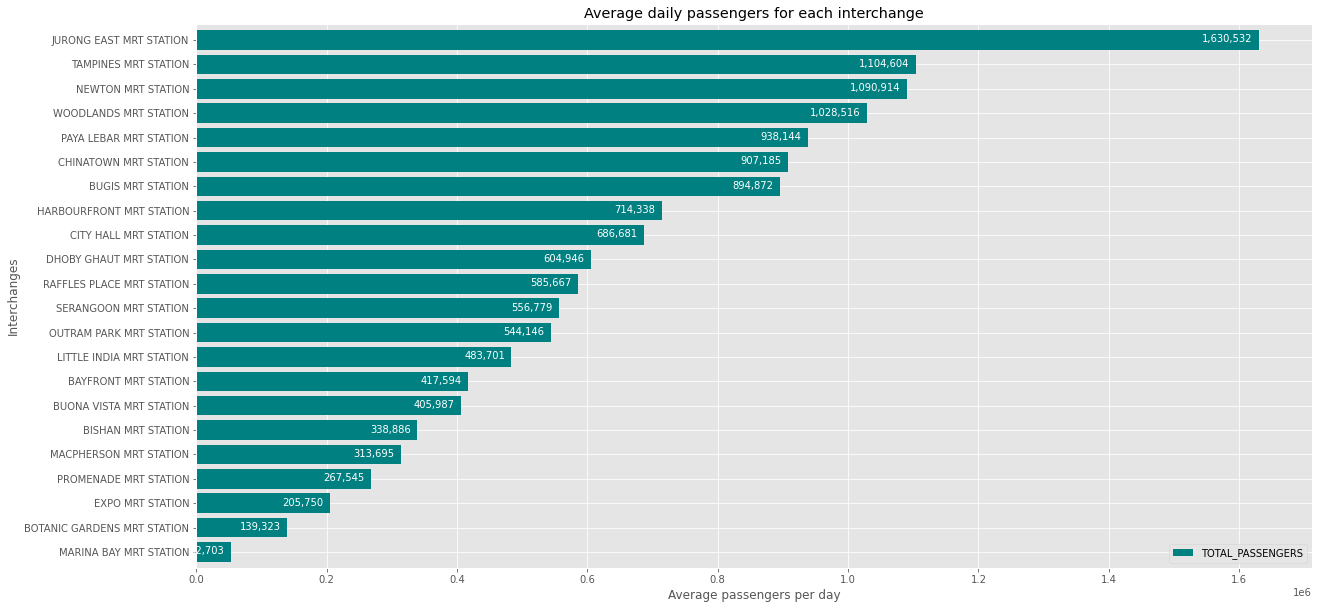

In [47]:
passengers_plot.sort_values('TOTAL_PASSENGERS', ascending=True, inplace=True)

ax = passengers_plot.plot(kind='barh', figsize=(20, 10), x='STN_NAME', y='TOTAL_PASSENGERS', color='teal' , width=0.8 )
ax.legend( loc='lower right' )

for index, value in enumerate(passengers_plot['TOTAL_PASSENGERS']): 
    label = format(int(value), ',') # format int with commas
    
    plt.annotate(label, xy=(value - 10000, index - 0.10), color='white', ha='right' )

plt.title('Average daily passengers for each interchange')
plt.xlabel('Average passengers per day')
plt.ylabel('Interchanges')
plt.show()


#### From the above, the top 5 interchanges are
- Jurong East
- Tampines
- Newton
- Woodlands
- Paya Lebar

<!-- Update the map for these 5 locations. -->

Now we will join the latitude and longitude from the previous section so that we can get a complete dataset with AVG_PASSENGERS.

In [48]:
passengers_plot.sort_values('STN_NAME', ascending=True, inplace=True)
passengers_plot.reset_index(inplace=True, drop=True)

mrt_interchanges_mean.sort_values('STN_NAME', ascending=True, inplace=True)
mrt_interchanges_mean.reset_index(inplace=True, drop=True)


all_interchanges = passengers_plot[ ['STN_NAME', 'TOTAL_PASSENGERS'] ].copy()
# # top5_interchanges.reset_index(inplace=True, drop=True)
# top5_interchanges = top5_interchanges.join( mrt_interchanges_mean, on='STN_NAME' )

all_interchanges = all_interchanges.join( mrt_interchanges_mean[['MEAN_LATITUDE', 'MEAN_LONGITUDE']] )


total_interchanges = all_interchanges.shape[0]

In [49]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

num=1
# add markers to map
for lat, lng, label in zip(all_interchanges['MEAN_LATITUDE'], all_interchanges['MEAN_LONGITUDE'], all_interchanges['STN_NAME']  ):
    label = folium.Popup( "(" + str(num) + ") " + label, parse_html=True)
  
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(map)  
    
    num+=1

    
    
map

#### In this section, we've cleaned up the raw data that are organised by station codes, and grouped them by interchange names. We now have 22 interchanges with average passengers count, latitude, and longitude

## 3. Getting Foursquare venues around each interchange

Next will get 100 venues for each of 22 interchange, in a radius of 1KM. We will also restrict it to `food` category only (which includes everything under F&B)

In [ ]:
CLIENT_ID = 'TRUNCATED' # your Foursquare ID
CLIENT_SECRET = 'TRUNCATED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section=food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print(venues_list)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['STN_NAME', 
                  'STN_LATITUDE', 
                  'STN_LONGITUDE', 
                  'VENUE', 
                  'VENUE_LATITUDE', 
                  'VENUE_LONGITUDE', 
                  'VENUE_CATEGORY']
    
    return(nearby_venues)

In [66]:
names = all_interchanges.loc[:, 'STN_NAME']
lats = all_interchanges.loc[:, 'MEAN_LATITUDE']
longs = all_interchanges.loc[:, 'MEAN_LONGITUDE']

nearby_venues = getNearbyVenues( names, lats, longs)
print('DONE')

BAYFRONT MRT STATION
BISHAN MRT STATION
BOTANIC GARDENS MRT STATION
BUGIS MRT STATION
BUONA VISTA MRT STATION
CHINATOWN MRT STATION
CITY HALL MRT STATION
DHOBY GHAUT MRT STATION
EXPO MRT STATION
HARBOURFRONT MRT STATION
JURONG EAST MRT STATION
LITTLE INDIA MRT STATION
MACPHERSON MRT STATION
MARINA BAY MRT STATION
NEWTON MRT STATION
OUTRAM PARK MRT STATION
PAYA LEBAR MRT STATION
PROMENADE MRT STATION
RAFFLES PLACE MRT STATION
SERANGOON MRT STATION
TAMPINES MRT STATION
WOODLANDS MRT STATION
[[('BAYFRONT MRT STATION', 1.281873788, 103.8590733, 'Spago', 1.2836150670349686, 103.86068226520949, 'Italian Restaurant'), ('BAYFRONT MRT STATION', 1.281873788, 103.8590733, 'Din Tai Fung 鼎泰豐', 1.28227, 103.857608, 'Dumpling Restaurant'), ('BAYFRONT MRT STATION', 1.281873788, 103.8590733, 'Waku Ghin', 1.2839768321341032, 103.8585974769517, 'Japanese Restaurant'), ('BAYFRONT MRT STATION', 1.281873788, 103.8590733, 'Adrift by David Myers', 1.2831409761088732, 103.86045270092075, 'Gastropub'), ('BAYFRO

In [67]:
nearby_venues.head()

,STN_NAME,STN_LATITUDE,STN_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,VENUE_CATEGORY
0,BAYFRONT MRT STATION,1.281874,103.859073,Spago,1.283615,103.860682,Italian Restaurant
1,BAYFRONT MRT STATION,1.281874,103.859073,Din Tai Fung 鼎泰豐,1.282270,103.857608,Dumpling Restaurant
2,BAYFRONT MRT STATION,1.281874,103.859073,Waku Ghin,1.283977,103.858597,Japanese Restaurant
3,BAYFRONT MRT STATION,1.281874,103.859073,Adrift by David Myers,1.283141,103.860453,Gastropub
4,BAYFRONT MRT STATION,1.281874,103.859073,CUT by Wolfgang Puck,1.285350,103.859440,Steakhouse


#### Check how many venues were returned

In [68]:
total_venues = nearby_venues.shape[0]
print("A total of {} venues were returned for the {} interchanges, for a given radius of 1KM".format(total_venues, total_interchanges))

A total of 1981 venues were returned for the 22 interchanges, for a given radius of 1KM


#### Check the top 20 venues

In [69]:
nearby_venues.groupby(['VENUE_CATEGORY']).count().sort_values('VENUE',ascending=False).reset_index().head(20)

,VENUE_CATEGORY,STN_NAME,STN_LATITUDE,STN_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE
0,Café,197,197,197,197,197,197
1,Japanese Restaurant,168,168,168,168,168,168
2,Chinese Restaurant,161,161,161,161,161,161
3,Food Court,109,109,109,109,109,109
4,Asian Restaurant,92,92,92,92,92,92
5,Bakery,90,90,90,90,90,90
6,Indian Restaurant,79,79,79,79,79,79
7,Italian Restaurant,60,60,60,60,60,60
8,Seafood Restaurant,55,55,55,55,55,55
9,Thai Restaurant,50,50,50,50,50,50


#### In the results above, row 11 (index 10) is with a category name 'Restaurant', which is quite generic. We will drop this category to improve the accuracy of the clustering later

In [70]:
nearby_venues = nearby_venues.drop( nearby_venues[nearby_venues['VENUE_CATEGORY']=='Restaurant'].index, axis=0 )

In [71]:
nearby_venues.groupby(['VENUE_CATEGORY']).count().sort_values('VENUE',ascending=False).reset_index().head(20)

,VENUE_CATEGORY,STN_NAME,STN_LATITUDE,STN_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE
0,Café,197,197,197,197,197,197
1,Japanese Restaurant,168,168,168,168,168,168
2,Chinese Restaurant,161,161,161,161,161,161
3,Food Court,109,109,109,109,109,109
4,Asian Restaurant,92,92,92,92,92,92
5,Bakery,90,90,90,90,90,90
6,Indian Restaurant,79,79,79,79,79,79
7,Italian Restaurant,60,60,60,60,60,60
8,Seafood Restaurant,55,55,55,55,55,55
9,Thai Restaurant,50,50,50,50,50,50


In [72]:
# check the shape again
total_venues = nearby_venues.shape[0]
print("A total of {} venues were returned for the {} interchanges, for a given radius of 1KM".format(total_venues, total_interchanges))

A total of 1932 venues were returned for the 22 interchanges, for a given radius of 1KM


#### Plot the top 20 categories across interchanges

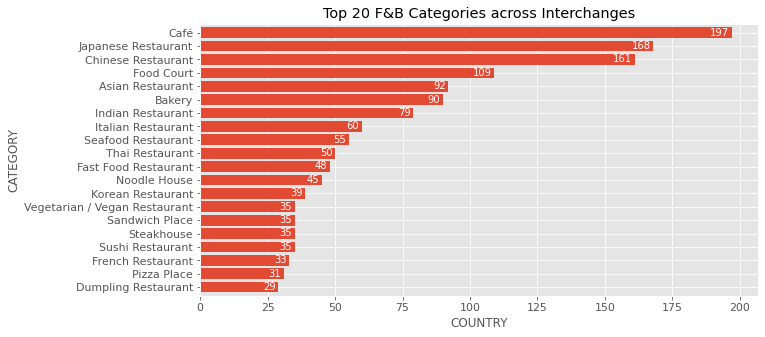

In [73]:

top_cats = nearby_venues.drop(['STN_LATITUDE', 'STN_LONGITUDE', 'VENUE_LATITUDE', 'VENUE_LONGITUDE'], 1).groupby(['VENUE_CATEGORY']).count().sort_values('VENUE',ascending=False).reset_index()
top_cats = top_cats.head(20)

ax = top_cats.plot(kind='barh', figsize=(10,5), x='VENUE_CATEGORY', y='VENUE',  fontsize=11, width=.8, legend=None)
ax.invert_yaxis()


plt.title('Top 20 F&B Categories across Interchanges')
plt.xlabel('COUNTRY')
plt.ylabel('CATEGORY')

for index, value in enumerate(top_cats['VENUE']): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(value - 1, index + 0.2), color='white', ha='right', fontsize=10 )

plt.show()



### Next, prepare the data for clustering

In [74]:
# one hot everything
categories_onehot = pd.get_dummies( nearby_venues[['VENUE_CATEGORY']], prefix="", prefix_sep="")
categories_onehot.shape

(1932, 87)

In [76]:
# add station name back to dataframe
categories_onehot['STN_NAME'] = nearby_venues['STN_NAME'] 

# move station name to the first column
fixed_columns = [categories_onehot.columns[-1]] + list(categories_onehot.columns[:-1])
categories_onehot = categories_onehot[fixed_columns]

categories_onehot.head()


,Wings Joint,STN_NAME,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Gastropub,German Restaurant,Greek Restaurant,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Macanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Pet Café,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Snack Place,Soba Restaurant,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [77]:
# Get the average of each venue by interchange
categories_onehot_grouped = categories_onehot.groupby('STN_NAME').mean().reset_index()
categories_onehot_grouped.head()

,STN_NAME,Wings Joint,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Gastropub,German Restaurant,Greek Restaurant,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Macanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Pet Café,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Snack Place,Soba Restaurant,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,BAYFRONT MRT STATION,0.000000,0.00,0.0,0.020000,0.0,0.000000,0.0,0.010000,0.03,0.00,0.030000,0.000000,0.0,0.000000,0.000000,0.120000,0.02,0.070000,0.01,0.0,0.0,0.010000,0.0,0.0,0.0,0.020000,0.01,0.01,0.01,0.050000,0.000000,0.030000,0.000000,0.000000,0.040000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.02,0.020000,0.010000,0.050000,0.00,0.120000,0.0,0.000000,0.0,0.00,0.000000,0.030000,0.000000,0.020000,0.020000,0.01,0.01,0.0,0.0,0.020000,0.00,0.010000,0.02,0.050000,0.00,0.030000,0.000000,0.0,0.01,0.0,0.000000,0.0,0.01,0.01,0.020000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.01,0.0,0.0,0.000000,0.010000
1,BISHAN MRT STATION,0.000000,0.00,0.0,0.069444,0.0,0.027778,0.0,0.055556,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.027778,0.069444,0.00,0.111111,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.013889,0.00,0.00,0.00,0.180556,0.013889,0.000000,0.013889,0.000000,0.013889,0.000000,0.0,0.0,0.013889,0.000000,0.0,0.00,0.013889,0.000000,0.041667,0.00,0.041667,0.0,0.013889,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.027778,0.00,0.00,0.0,0.0,0.027778,0.00,0.000000,0.00,0.000000,0.00,0.069444,0.013889,0.0,0.00,0.0,0.013889,0.0,0.00,0.00,0.027778,0.027778,0.0,0.0,0.000000,0.0,0.055556,0.00,0.0,0.0,0.013889,0.000000
2,BOTANIC GARDENS MRT STATION,0.000000,0.00,0.0,0.060000,0.0,0.000000,0.0,0.040000,0.02,0.00,0.000000,0.020000,0.0,0.000000,0.000000,0.200000,0.00,0.060000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.02,0.00,0.040000,0.000000,0.060000,0.000000,0.000000,0.020000,0.000000,0.0,0.0,0.000000,0.020000,0.0,0.00,0.060000,0.020000,0.020000,0.00,0.060000,0.0,0.000000,0.0,0.04,0.000000,0.000000,0.000000,0.020000,0.040000,0.00,0.00,0.0,0.0,0.020000,0.00,0.000000,0.00,0.000000,0.02,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00,0.04,0.040000,0.000000,0.0,0.0,0.000000,0.0,0.060000,0.00,0.0,0.0,0.000000,0.000000
3,BUGIS MRT STATION,0.010638,0.00,0.0,0.021277,0.0,0.010638,0.0,0.053191,0.00,0.00,0.021277,0.021277,0.0,0.010638,0.000000,0.138298,0.00,0.074468,0.00,0.0,0.0,0.031915,0.0,0.0,0.0,0.021277,0.00,0.00,0.00,0.021277,0.000000,0.021277,0.000000,0.010638,0.010638,0.021277,0.0,0.0,0.000000,0.021277,0.0,0.00,0.053191,0.021277,0.031915,0.00,0.127660,0.0,0.000000,0.0,0.00,0.010638,0.010638,0.010638,0.010638,0.021277,0.00,0.00,0.0,0.0,0.010638,0.00,0.031915,0.00,0.010638,0.00,0.010638,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00,0.00,0.000000,0.021277,0.0,0.0,0.010638,0.0,0.031915,0.00,0.0,0.0,0.031915,0.021277
4,BUONA VISTA MRT STATION,0.000000,0.03,0.0,0.030000,

In [78]:
categories_onehot_grouped.shape

(22, 88)

In [79]:
# print the top 5 venues per interchange
num_top_venues = 5

for hood in categories_onehot_grouped['STN_NAME']:
    print("----"+hood+"----")
    temp = categories_onehot_grouped[categories_onehot_grouped['STN_NAME'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BAYFRONT MRT STATION----
                 venue  freq
0                 Café  0.12
1  Japanese Restaurant  0.12
2   Chinese Restaurant  0.07
3       Sandwich Place  0.05
4   Italian Restaurant  0.05


----BISHAN MRT STATION----
                venue  freq
0          Food Court  0.18
1  Chinese Restaurant  0.11
2    Asian Restaurant  0.07
3  Seafood Restaurant  0.07
4                Café  0.07


----BOTANIC GARDENS MRT STATION----
                 venue  freq
0                 Café  0.20
1    French Restaurant  0.06
2     Asian Restaurant  0.06
3  Japanese Restaurant  0.06
4   Chinese Restaurant  0.06


----BUGIS MRT STATION----
                 venue  freq
0                 Café  0.14
1  Japanese Restaurant  0.13
2   Chinese Restaurant  0.07
3               Bakery  0.05
4    Indian Restaurant  0.05


----BUONA VISTA MRT STATION----
                 venue  freq
0                 Café  0.10
1               Bakery  0.08
2           Food Court  0.07
3  Japanese Restaurant  0.06
4   Chi

In [80]:
# row is the row with all the venues
def return_most_common_venues(row, num_top_venues):
    # cut the column, from the 2nd column onwards (skipping the first)
    row_categories = row.iloc[1:]
    # sort the values by highest mean first
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # return the top 10
    return row_categories_sorted.index.values[0:num_top_venues]

In [86]:
# Get the 10 most comment categories
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['STN_NAME']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
# assign all the neighborhoods first
neighborhoods_venues_sorted['STN_NAME'] = categories_onehot_grouped['STN_NAME']

# start a loop based on grouped neighborhood
for ind in np.arange(categories_onehot_grouped.shape[0]):
    # manhattan_grouped.iloc[ind, :] - cuts the row
    # num_top_venues is 10, as per above
    
    # assign the value on this row, replacing 2nd column onwards
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(categories_onehot_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,STN_NAME,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,BAYFRONT MRT STATION,Café,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Food Court,Italian Restaurant,Gastropub,Seafood Restaurant,Bistro,Buffet
1,BISHAN MRT STATION,Food Court,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Café,Bakery,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant
2,BOTANIC GARDENS MRT STATION,Café,Japanese Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Thai Restaurant,Indian Restaurant,Spanish Restaurant,Steakhouse,Noodle House
3,BUGIS MRT STATION,Café,Japanese Restaurant,Chinese Restaurant,Bakery,Indian Restaurant,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Ramen Restaurant
4,BUONA VISTA MRT STATION,Café,Bakery,Food Court,Japanese Restaurant,Indian Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Salad Place,American Restaurant


## 4. Cluster 


Cluster the categories into 5 clusters.

In [87]:
# set number of clusters
kclusters = 5

categories_grouped_clustering = categories_onehot_grouped.drop('STN_NAME', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(categories_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 0, 4, 1, 1, 4, 4, 0, 1], dtype=int32)

In [88]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

interchanges_merged = all_interchanges

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
interchanges_merged = interchanges_merged.join(neighborhoods_venues_sorted.set_index('STN_NAME'), on='STN_NAME')

interchanges_merged.head() # check the last columns!

,STN_NAME,TOTAL_PASSENGERS,MEAN_LATITUDE,MEAN_LONGITUDE,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,BAYFRONT MRT STATION,417594.0,1.281874,103.859073,1,Café,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Food Court,Italian Restaurant,Gastropub,Seafood Restaurant,Bistro,Buffet
1,BISHAN MRT STATION,338886.5,1.351074,103.848645,2,Food Court,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Café,Bakery,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant
2,BOTANIC GARDENS MRT STATION,139323.5,1.322267,103.815562,0,Café,Japanese Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Thai Restaurant,Indian Restaurant,Spanish Restaurant,Steakhouse,Noodle House
3,BUGIS MRT STATION,894872.5,1.300008,103.856281,4,Café,Japanese Restaurant,Chinese Restaurant,Bakery,Indian Restaurant,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Ramen Restaurant
4,BUONA VISTA MRT STATION,405987.5,1.306838,103.790434,1,Café,Bakery,Food Court,Japanese Restaurant,Indian Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Salad Place,American Restaurant


And finally, we will plot these on the map

In [89]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(interchanges_merged['MEAN_LATITUDE'], interchanges_merged['MEAN_LONGITUDE'], interchanges_merged['STN_NAME'], interchanges_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### We can examine the clusters below

## Cluster 0 (Red)

In [92]:
interchanges_merged.loc[interchanges_merged['Cluster Labels'] == 0, interchanges_merged.columns[[0] + list(range(5, interchanges_merged.shape[1]))]]

,STN_NAME,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
2,BOTANIC GARDENS MRT STATION,Café,Japanese Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Thai Restaurant,Indian Restaurant,Spanish Restaurant,Steakhouse,Noodle House
8,EXPO MRT STATION,Café,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Asian Restaurant,Food Court,Japanese Restaurant,Pizza Place,Sandwich Place,Breakfast Spot


## Cluster 1 (Purple)

In [90]:
interchanges_merged.loc[interchanges_merged['Cluster Labels'] == 1, interchanges_merged.columns[[0] + list(range(5, interchanges_merged.shape[1]))]]

,STN_NAME,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,BAYFRONT MRT STATION,Café,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Food Court,Italian Restaurant,Gastropub,Seafood Restaurant,Bistro,Buffet
4,BUONA VISTA MRT STATION,Café,Bakery,Food Court,Japanese Restaurant,Indian Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Salad Place,American Restaurant
5,CHINATOWN MRT STATION,Chinese Restaurant,Japanese Restaurant,Food Court,Korean Restaurant,Italian Restaurant,Seafood Restaurant,Soup Place,Café,Vegetarian / Vegan Restaurant,Spanish Restaurant
9,HARBOURFRONT MRT STATION,Café,Japanese Restaurant,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Food Court,Noodle House,Seafood Restaurant,Vietnamese Restaurant
10,JURONG EAST MRT STATION,Café,Japanese Restaurant,Food Court,Chinese Restaurant,Bakery,Sandwich Place,Asian Restaurant,Thai Restaurant,Seafood Restaurant,Sushi Restaurant
13,MARINA BAY MRT STATION,Café,Japanese Restaurant,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Korean Restaurant,Salad Place,Sandwich Place,Food Court,Noodle House
14,NEWTON MRT STATION,Chinese Restaurant,Café,Asian Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,American Restaurant,Noodle House,Bakery
15,OUTRAM PARK MRT STATION,Japanese Restaurant,Bakery,Italian Restaurant,Seafood Restaurant,Café,Food Court,Chinese Restaurant,Korean Restaurant,Tapas Restaurant,Ramen Restaurant
18,RAFFLES PLACE MRT STATION,Café,Japanese Restaurant,Seafood Restaurant,Food Court,Chinese Restaurant,Korean Restaurant,Italian Restaurant,Dumpling Restaurant,Sandwich Place,French Restaurant
19,SERANGOON MRT STATION,Chinese Restaurant,Asian Restaurant,Café,Japanese Restaurant,Indian Restaurant,Bakery,Fast Food Restaurant,Seafood Restaurant,Noodle House,Thai Restaurant


## Cluster 2 (Blue)

In [91]:
interchanges_merged.loc[interchanges_merged['Cluster Labels'] == 2, interchanges_merged.columns[[0] + list(range(5, interchanges_merged.shape[1]))]]

,STN_NAME,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
1,BISHAN MRT STATION,Food Court,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Café,Bakery,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant
12,MACPHERSON MRT STATION,Food Court,Asian Restaurant,Chinese Restaurant,Fast Food Restaurant,Bakery,Café,Vegetarian / Vegan Restaurant,Japanese Restaurant,Noodle House,Seafood Restaurant
16,PAYA LEBAR MRT STATION,Chinese Restaurant,Asian Restaurant,Food Court,Fast Food Restaurant,Noodle House,Bakery,Seafood Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Café
20,TAMPINES MRT STATION,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,Café,Food Court,Bakery,Sushi Restaurant,Fried Chicken Joint,Japanese Restaurant,Indian Restaurant
21,WOODLANDS MRT STATION,Food Court,Café,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Asian Restaurant,Bakery,Indian Restaurant,Sandwich Place,Chinese Restaurant


## Cluster 3 (Green)

In [93]:
interchanges_merged.loc[interchanges_merged['Cluster Labels'] == 3, interchanges_merged.columns[[0] + list(range(5, interchanges_merged.shape[1]))]]

,STN_NAME,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
11,LITTLE INDIA MRT STATION,Indian Restaurant,Chinese Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Japanese Restaurant,Sushi Restaurant,Indonesian Restaurant,Noodle House,Dim Sum Restaurant


## Cluster 4 (Orange)

In [94]:
interchanges_merged.loc[interchanges_merged['Cluster Labels'] == 4, interchanges_merged.columns[[0] + list(range(5, interchanges_merged.shape[1]))]]

,STN_NAME,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
3,BUGIS MRT STATION,Café,Japanese Restaurant,Chinese Restaurant,Bakery,Indian Restaurant,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Ramen Restaurant
6,CITY HALL MRT STATION,Japanese Restaurant,Café,Italian Restaurant,Chinese Restaurant,Buffet,Bakery,French Restaurant,Dim Sum Restaurant,Vegetarian / Vegan Restaurant,Steakhouse
7,DHOBY GHAUT MRT STATION,Japanese Restaurant,Café,Korean Restaurant,Bakery,Steakhouse,Chinese Restaurant,Asian Restaurant,Indian Restaurant,French Restaurant,Sushi Restaurant
17,PROMENADE MRT STATION,Japanese Restaurant,Café,Bakery,Buffet,Steakhouse,Chinese Restaurant,Italian Restaurant,Thai Restaurant,Indian Restaurant,Dumpling Restaurant
